# **Desafio IHM Stefanini - 04 - Prophet**

## **Carregando as bibliotecas**

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from optuna.samplers import TPESampler

import math

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

## **Configurações do notebook**

In [49]:
# Configuração gerais
%matplotlib inline
sns.set(style='white')
pd.set_option('display.max_columns', None)

# Random seed
RANDOM_SEED = 1

## **Carregando os dados**

In [50]:
df = pd.read_csv("dados_ihm_stefanini/flotation_hour.csv")

In [51]:
df['date'] = pd.to_datetime(df['date'])

In [52]:
df.head()

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,55.2,16.98,3162.625026,578.786678,398.753368,10.113487,1.729558,251.166672,250.226086,250.178287,295.096,306.4,251.232529,250.208184,450.383776,446.891845,450.474523,449.912259,455.792161,464.383310,450.532747,66.91,1.31
1,2017-03-10 02:00:00,55.2,16.98,3133.256389,537.219661,399.871822,10.129742,1.667784,249.880589,250.214050,250.033317,295.096,306.4,249.909494,249.897572,449.373361,450.249356,450.081222,450.328806,448.722983,455.501528,451.387700,67.06,1.11
2,2017-03-10 03:00:00,55.2,16.98,3479.482944,591.906744,398.763806,10.048403,1.732711,250.161328,250.104167,250.046350,295.096,306.4,250.242161,250.484183,449.972878,450.868711,450.901822,451.145822,451.134189,459.981311,450.296722,66.97,1.27
3,2017-03-10 04:00:00,55.2,16.98,3228.036436,593.170106,399.866983,9.918614,1.731056,250.208772,250.204761,250.120861,295.096,306.4,249.825122,250.157622,487.940706,491.462111,487.387206,494.528183,495.664011,502.763850,494.939889,66.75,1.36
4,2017-03-10 05:00:00,55.2,16.98,3327.280739,619.710806,399.615089,9.746029,1.765879,249.917800,250.160494,250.013500,295.096,306.4,250.249600,250.078639,549.031539,549.983156,549.459572,549.975483,549.512533,560.696300,550.271772,66.63,1.34


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4415 entries, 0 to 4414
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date                          4415 non-null   datetime64[ns]
 1   % Iron Feed                   4415 non-null   float64       
 2   % Silica Feed                 4415 non-null   float64       
 3   Starch Flow                   4415 non-null   float64       
 4   Amina Flow                    4415 non-null   float64       
 5   Ore Pulp Flow                 4415 non-null   float64       
 6   Ore Pulp pH                   4415 non-null   float64       
 7   Ore Pulp Density              4415 non-null   float64       
 8   Flotation Column 01 Air Flow  4415 non-null   float64       
 9   Flotation Column 02 Air Flow  4415 non-null   float64       
 10  Flotation Column 03 Air Flow  4415 non-null   float64       
 11  Flotation Column 04 Air Flow  

## **Funções necessárias**

In [54]:
# Métricas
def eval_metrics(y_true, y_pred):
    metrics_dict = dict()
    metrics_dict['RMSE'] = np.sqrt(mean_squared_error(y_true, y_pred))
    metrics_dict['MAE'] = mean_absolute_error(y_true, y_pred)
    metrics_dict['MAPE'] = (np.mean(np.true_divide(np.abs(y_true-y_pred), y_true)))*100
    return metrics_dict

## **Ajustes no conjunto de dados para o modelo Prophet**

**Renomeando as colunas `date` e `% Silica Concentrate`:**

In [55]:
df.rename(columns={"date": "ds", "% Silica Concentrate": "y"}, inplace=True)

**Adicionando as colunas `cap` e `floor` ao conjunto de dados:**

In [56]:
print(f"Valor mínimo do preço médio: {df.y.min()}")
print(f"Valor máximo do preço médio: {df.y.max()}")

Valor mínimo do preço médio: 0.6
Valor máximo do preço médio: 5.53


In [57]:
df['cap'] = math.ceil(df.y.max() + 1)

if df.y.min() <= 1:
    df['floor'] = 0.001
else:
    df['floor'] = math.floor(df.y.min() - 1)

## **Separando os dados em treino e teste:**

**Treino:**

In [58]:
treino = df.drop(df.index[-24:])
treino

,ds,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,y,cap,floor
0,2017-03-10 01:00:00,55.20,16.98,3162.625026,578.786678,398.753368,10.113487,1.729558,251.166672,250.226086,250.178287,295.096000,306.400000,251.232529,250.208184,450.383776,446.891845,450.474523,449.912259,455.792161,464.383310,450.532747,66.91,1.31,7,0.001
1,2017-03-10 02:00:00,55.20,16.98,3133.256389,537.219661,399.871822,10.129742,1.667784,249.880589,250.214050,250.033317,295.096000,306.400000,249.909494,249.897572,449.373361,450.249356,450.081222,450.328806,448.722983,455.501528,451.387700,67.06,1.11,7,0.001
2,2017-03-10 03:00:00,55.20,16.98,3479.482944,591.906744,398.763806,10.048403,1.732711,250.161328,250.104167,250.046350,295.096000,306.400000,250.242161,250.484183,449.972878,450.868711,450.901822,451.145822,451.134189,459.981311,450.296722,66.97,1.27,7,0.001
3,2017-03-10 04:00:00,55.20,16.98,3228.036436,593.170106,399.866983,9.918614,1.731056,250.208772,250.204761,250.120861,295.096000,306.400000,249.825122,250.157622,487.940706,491.462111,487.387206,494.528183,495.664011,502.763850,494.939889,66.75,1.36,7,0.001
4,2017-03-10 05:00:00,55.20,16.98,3327.280739,619.710806,399.615089,9.746029,1.765879,249.917800,250.160494,250.013500,295.096000,306.400000,250.249600,250.078639,549.031539,549.983156,549.459572,549.975483,549.512533,560.696300,550.271772,66.63,1.34,7,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4386,2017-09-08 19:00:00,59.55,8.45,1814.082561,286.948050,378.794775,9.224923,1.596176,299.937494,300.281400,299.930189,299.929867,300.045589,299.907800,300.612778,399.246644,499.504078,399.884889,403.851878,400.782472,400.266183,402.725244,65.12,1.33,7,0.001
4387,2017-09-08 20:00:00,59.55,8.45,2751.251532,306.293311,380.472236,9.387055,1.630635,299.836139,300.033742,300.003611,299.913328,300.002856,300.073050,300.030389,400.178172,498.873272,399.506600,400.187917,400.958233,400.416839,400.626439,64.91,1.50,7,0.001
4388,2017-09-08 21:00:00,59.55,8.45,1557.087077,300.106875,377.982556,9.500313,1.631130,299.882483,300.264511,299.929856,299.893272,299.882983,299.432156,299.994811,405.193939,502.707611,406.744867,403.466583,400.435589,400.730467,402.128683,63.91,2.94,7,0.001
4389,2017-09-08 22:00:00,59.55,8.45,2796.314864,284.769595,377.172188,9.752432,1.610417,300.044350,299.575717,299.945356,299.905850,299.735056,299.839067,300.091883,421.995161,499.303681,432.606683,393.067961,398.634122,399.848311,399.132417,63.54,4.10,7,0.001


**Teste:**

In [59]:
teste = df[-24:].reset_index(drop=True)
teste

,ds,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,y,cap,floor
0,2017-09-09 00:00:00,59.55,8.45,2926.600829,489.406744,380.761944,9.654977,1.655980,299.824122,299.655028,299.875678,299.907217,299.834867,299.965233,299.746917,399.708189,497.237556,400.154611,399.308767,400.392872,399.830311,398.490011,63.00,4.18,7,0.001
1,2017-09-09 01:00:00,49.56,24.20,2044.172218,477.120444,380.884986,9.618139,1.624229,299.906928,299.673750,300.025150,299.933200,299.986756,300.045628,300.763156,399.304811,498.109178,399.790989,400.914261,401.113000,399.647133,400.393506,63.47,3.24,7,0.001
2,2017-09-09 02:00:00,49.56,24.20,1549.602767,393.205100,379.456711,9.227681,1.557234,299.931333,300.462744,299.970978,299.919117,300.177928,299.517067,299.214833,400.484483,497.200450,399.585522,395.856211,399.833417,399.686828,399.060811,64.86,2.34,7,0.001
3,2017-09-09 03:00:00,49.56,24.20,2565.138464,365.719417,379.711595,9.158911,1.536460,299.822594,299.747856,299.868217,299.903778,299.993372,300.250628,299.799744,400.144317,499.156167,399.709472,402.762550,401.223800,399.778122,400.563972,64.03,3.07,7,0.001
4,2017-09-09 04:00:00,49.56,24.20,3112.085250,497.625356,379.951077,9.429278,1.674363,299.922317,299.763067,299.963972,299.901339,299.636789,300.072667,300.665750,399.893378,499.402494,399.903489,399.245172,400.171856,399.902689,400.554867,63.69,3.12,7,0.001
5,2017-09-09 05:00:00,49.56,24.20,1516.844243,502.239056,380.650353,9.696310,1.657818,299.939317,299.846478,299.919594,299.896106,299.913817,299.754911,300.944667,399.355583,497.898572,399.471167,398.424339,401.618111,399.516872,398.913206,63.49,3.26,7,0.001
6,2017-09-09 06:00:00,49.56,24.20,2200.388426,416.533433,380.653842,9.665631,1.548030,299.926428,299.909189,299.881478,299.947156,299.932856,300.273433,299.582944,399.125033,497.775628,399.870017,398.829000,399.900233,400.219183,398.769206,65.00,1.93,7,0.001
7,2017-09-09 07:00:00,54.63,12.90,3260.616611,555.557256,411.258554,9.535045,1.649501,300.116600,300.010683,299.950478,299.958794,300.079183,300.527972,300.563000,399.936950,502.032228,399.838567,402.260050,398.257172,400.057122,401.394289,64.17,2.23,7,0.001
8,2017-09-09 08:00:00,54.63,12.90,3673.921111,582.045314,413.685193,9.644717,1.651699,299.994789,300.013144,299.919567,299.916439,299.741683,299.539206,299.881772,399.413894,501.466511,398.527189,400.643422,399.362000,400.516222,401.502011,64.40,2.15,7,0.001
9,2017-09-09 09:00:00,54.63,12.90,3840.586889,586.408950,415.232145,9.765653,1.640704,300.039483,299.637367,299.994789,299.913706,299.953611,300.466533,301.029300,398.997778,498.230917,401.166506,401.423856,398.713889,398.460006,398.872917,65.26,2.30,7,0.001


## **Modelo Prophet - Multivariado com todas as variáveis**

### **Ajuste dos hiperparâmetros com Optuna**

Os hiperparâmetros qque serão ajustados serão:
- growth;
- changepoint_prior_scale.

In [60]:
def objective(trial):
    growth = trial.suggest_categorical('growth', ['linear', 'logistic', 'flat'])
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.00001, 0.9)

    # Instanciando o modelo
    m = Prophet(growth=growth, changepoint_prior_scale=changepoint_prior_scale)
    m.add_regressor("% Iron Feed")
    m.add_regressor("% Silica Feed")
    m.add_regressor("Starch Flow")
    m.add_regressor("Amina Flow")
    m.add_regressor("Ore Pulp Flow")
    m.add_regressor("Ore Pulp pH")
    m.add_regressor("Ore Pulp Density")
    m.add_regressor("Flotation Column 01 Air Flow")
    m.add_regressor("Flotation Column 02 Air Flow")
    m.add_regressor("Flotation Column 03 Air Flow")
    m.add_regressor("Flotation Column 04 Air Flow")
    m.add_regressor("Flotation Column 05 Air Flow")
    m.add_regressor("Flotation Column 06 Air Flow")
    m.add_regressor("Flotation Column 07 Air Flow")
    m.add_regressor("Flotation Column 01 Level")
    m.add_regressor("Flotation Column 02 Level")
    m.add_regressor("Flotation Column 03 Level")
    m.add_regressor("Flotation Column 04 Level")
    m.add_regressor("Flotation Column 05 Level")
    m.add_regressor("Flotation Column 06 Level")
    m.add_regressor("Flotation Column 07 Level")
    m.add_regressor("% Iron Concentrate")
    
    # Treinando o modelo
    m.fit(treino)

    # Fazendo previsões
    val = treino[-24:].reset_index(drop=True)
    previsoes = m.predict(val)

    # Calculado o MAPE
    y_true = val.y.values
    y_pred = previsoes.yhat.values
    mape = (np.mean(np.true_divide(np.abs(y_true-y_pred), y_true)))*100

    return mape

In [61]:
sampler = TPESampler(seed=RANDOM_SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)
#optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=50)

[I 2024-10-19 17:37:01,621] A new study created in memory with name: no-name-8d218bad-b8dc-490e-8328-59cea5d82c64
17:37:02 - cmdstanpy - INFO - Chain [1] start processing
17:37:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-10-19 17:37:03,514] Trial 0 finished with value: 17.88277988385197 and parameters: {'growth': 'logistic', 'changepoint_prior_scale': 0.2721062920429295}. Best is trial 0 with value: 17.88277988385197.
17:37:04 - cmdstanpy - INFO - Chain [1] start processing
17:37:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-10-19 17:37:04,188] Trial 1 finished with value: 21.24331094610337 and parameters: {'growth': 'flat', 'changepoint_prior_scale': 0.3110111987314726}. Best is trial 0 with value: 17.88277988385197.
17:37:04 - cmdstanpy - INFO - Chain [1] start processing
17:37:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-10-19 17:37:07,603] Trial 2 finished with value: 17.1873410578678 and parameters: {'growth': 'logistic', 'changepoint_prior_s

In [62]:
melhores_parametros = study.best_params

print(f"Melhor MAPE: {study.best_trial.value}")
print(f"Melhores parâmetros: {study.best_params}")

Melhor MAPE: 16.99782542909681
Melhores parâmetros: {'growth': 'logistic', 'changepoint_prior_scale': 0.800745626696538}


### **Treinando o modelo com os parâmetros ajustados**

In [63]:
m = Prophet(
        growth=melhores_parametros['growth'],
        changepoint_prior_scale=melhores_parametros['changepoint_prior_scale']
)

m.add_regressor("% Iron Feed")
m.add_regressor("% Silica Feed")
m.add_regressor("Starch Flow")
m.add_regressor("Amina Flow")
m.add_regressor("Ore Pulp Flow")
m.add_regressor("Ore Pulp pH")
m.add_regressor("Ore Pulp Density")
m.add_regressor("Flotation Column 01 Air Flow")
m.add_regressor("Flotation Column 02 Air Flow")
m.add_regressor("Flotation Column 03 Air Flow")
m.add_regressor("Flotation Column 04 Air Flow")
m.add_regressor("Flotation Column 05 Air Flow")
m.add_regressor("Flotation Column 06 Air Flow")
m.add_regressor("Flotation Column 07 Air Flow")
m.add_regressor("Flotation Column 01 Level")
m.add_regressor("Flotation Column 02 Level")
m.add_regressor("Flotation Column 03 Level")
m.add_regressor("Flotation Column 04 Level")
m.add_regressor("Flotation Column 05 Level")
m.add_regressor("Flotation Column 06 Level")
m.add_regressor("Flotation Column 07 Level")
m.add_regressor("% Iron Concentrate")

m.fit(treino)

17:39:15 - cmdstanpy - INFO - Chain [1] start processing
17:39:19 - cmdstanpy - INFO - Chain [1] done processing


### **Avaliando o modelo**

In [64]:
# Previsões
y_pred = m.predict(teste)

In [65]:
# Visualizando as métricas
eval_metrics(teste.y.values, y_pred.yhat.values)

{'RMSE': 0.5973249568733879,
 'MAE': 0.46475201886581613,
 'MAPE': 21.64374467002901}

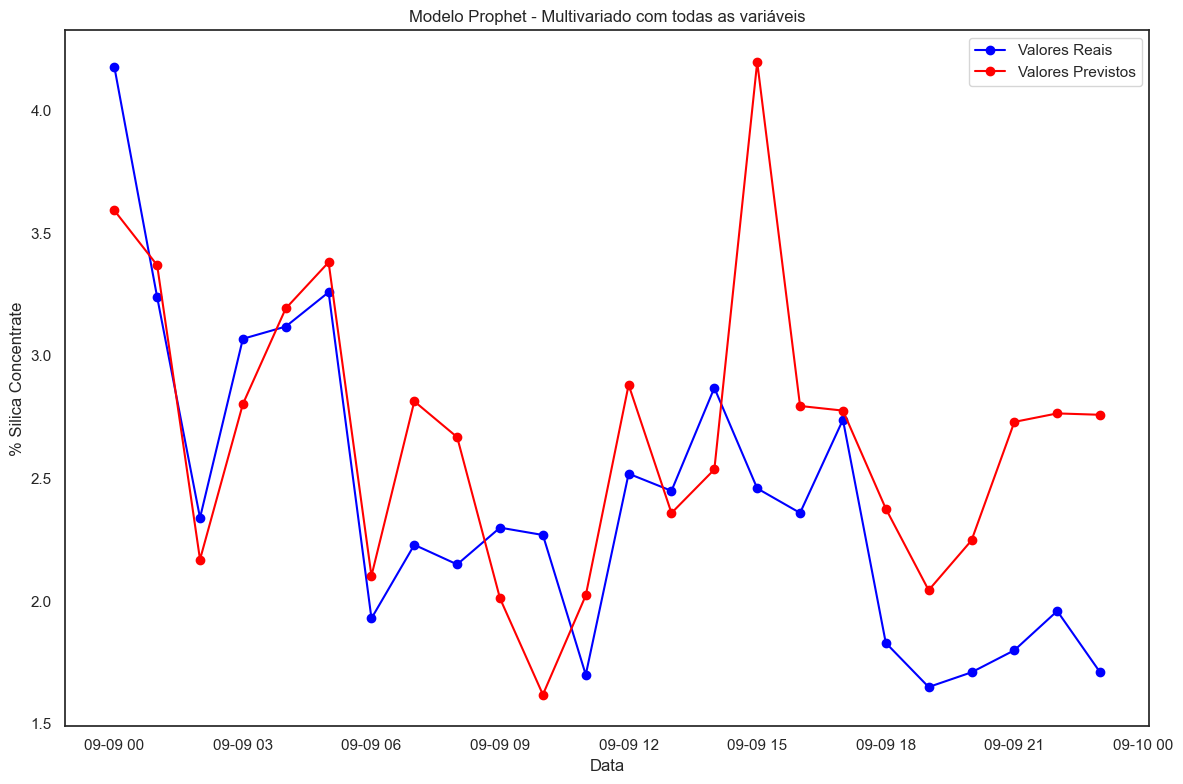

In [66]:
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(teste.ds, teste.y.values, label="Valores Reais", marker="o", color="blue")
plt.plot(y_pred.ds, y_pred.yhat.values, label="Valores Previstos", marker="o", color="red")

plt.ylabel("% Silica Concentrate")
plt.xlabel("Data")
plt.title("Modelo Prophet - Multivariado com todas as variáveis")
plt.legend()

plt.tight_layout()

## **Modelo Prophet - Multivariado com as variáveis selecionadas**

### **Ajuste dos hiperparâmetros com Optuna**

In [67]:
def objective(trial):
    growth = trial.suggest_categorical('growth', ['linear', 'logistic', 'flat'])
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.00001, 0.9)

    # Instanciando o modelo
    m = Prophet(growth=growth, changepoint_prior_scale=changepoint_prior_scale)
    m.add_regressor("Amina Flow")
    m.add_regressor("Ore Pulp pH")
    m.add_regressor("Flotation Column 01 Air Flow")
    m.add_regressor("Flotation Column 02 Air Flow")
    m.add_regressor("Flotation Column 03 Air Flow")
    m.add_regressor("Flotation Column 04 Level")
    m.add_regressor("Flotation Column 05 Level")
    m.add_regressor("Flotation Column 06 Level")
    m.add_regressor("Flotation Column 07 Level")
    m.add_regressor("% Iron Concentrate")
    
    # Treinando o modelo
    m.fit(treino)

    # Fazendo previsões
    val = treino[-24:].reset_index(drop=True)
    previsoes = m.predict(val)

    # Calculado o MAPE
    y_true = val.y.values
    y_pred = previsoes.yhat.values
    mape = (np.mean(np.true_divide(np.abs(y_true-y_pred), y_true)))*100

    return mape

In [68]:
sampler = TPESampler(seed=RANDOM_SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)
#optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=50)

[I 2024-10-19 17:39:28,901] A new study created in memory with name: no-name-4ae27c0c-1cb1-4bb6-8947-cf0b5c123baf
17:39:29 - cmdstanpy - INFO - Chain [1] start processing
17:39:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-10-19 17:39:30,518] Trial 0 finished with value: 17.832590759750488 and parameters: {'growth': 'logistic', 'changepoint_prior_scale': 0.2721062920429295}. Best is trial 0 with value: 17.832590759750488.
17:39:30 - cmdstanpy - INFO - Chain [1] start processing
17:39:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-10-19 17:39:31,024] Trial 1 finished with value: 23.055286367429424 and parameters: {'growth': 'flat', 'changepoint_prior_scale': 0.3110111987314726}. Best is trial 0 with value: 17.832590759750488.
17:39:31 - cmdstanpy - INFO - Chain [1] start processing
17:39:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-10-19 17:39:33,894] Trial 2 finished with value: 17.5530356991139 and parameters: {'growth': 'logistic', 'changepoint_pri

In [69]:
melhores_parametros = study.best_params

print(f"Melhor MAPE: {study.best_trial.value}")
print(f"Melhores parâmetros: {study.best_params}")

Melhor MAPE: 17.442037310159556
Melhores parâmetros: {'growth': 'logistic', 'changepoint_prior_scale': 0.8358188370911632}


### **Treinando o modelo com os parâmetros ajustados**

In [70]:
m = Prophet(
        growth=melhores_parametros['growth'],
        changepoint_prior_scale=melhores_parametros['changepoint_prior_scale']
)

m.add_regressor("Amina Flow")
m.add_regressor("Ore Pulp pH")
m.add_regressor("Flotation Column 01 Air Flow")
m.add_regressor("Flotation Column 02 Air Flow")
m.add_regressor("Flotation Column 03 Air Flow")
m.add_regressor("Flotation Column 04 Level")
m.add_regressor("Flotation Column 05 Level")
m.add_regressor("Flotation Column 06 Level")
m.add_regressor("Flotation Column 07 Level")
m.add_regressor("% Iron Concentrate")

m.fit(treino)

17:41:30 - cmdstanpy - INFO - Chain [1] start processing
17:41:33 - cmdstanpy - INFO - Chain [1] done processing


### **Avaliando o modelo**

In [71]:
# Previsões
y_pred = m.predict(teste)

In [72]:
# Visualizando as métricas
eval_metrics(teste.y.values, y_pred.yhat.values)

{'RMSE': 0.5676174443183053,
 'MAE': 0.428476124539384,
 'MAPE': 19.963127513729425}

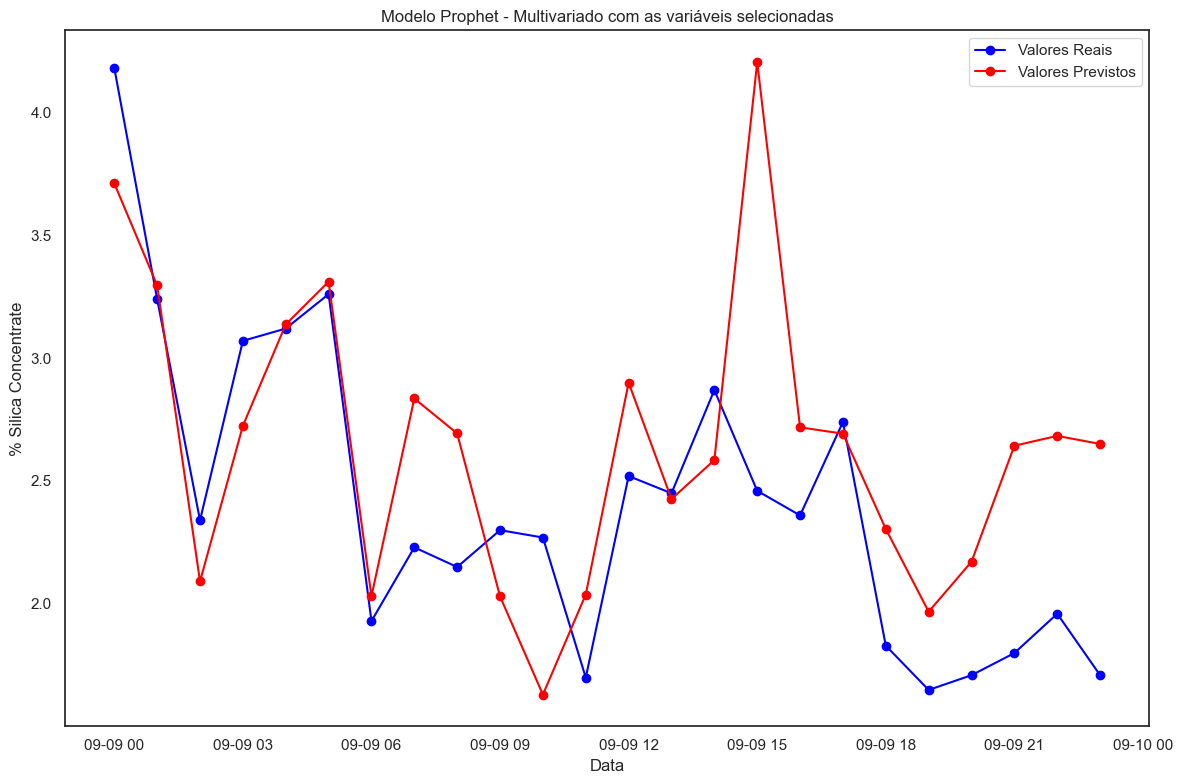

In [73]:
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(teste.ds, teste.y.values, label="Valores Reais", marker="o", color="blue")
plt.plot(y_pred.ds, y_pred.yhat.values, label="Valores Previstos", marker="o", color="red")

plt.ylabel("% Silica Concentrate")
plt.xlabel("Data")
plt.title("Modelo Prophet - Multivariado com as variáveis selecionadas")
plt.legend()

plt.tight_layout()
#plt.savefig("dados_ihm_stefanini/prophet_multi_selec.png")

## **Modelo Prophet - Multivariado com todas as variáveis, excluindo apenas `% Iron Concentrate`**

### **Ajuste dos hiperparâmetros com Optuna**

In [74]:
def objective(trial):
    growth = trial.suggest_categorical('growth', ['linear', 'logistic', 'flat'])
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.00001, 0.9)

    # Instanciando o modelo
    m = Prophet(growth=growth, changepoint_prior_scale=changepoint_prior_scale)
    m.add_regressor("% Iron Feed")
    m.add_regressor("% Silica Feed")
    m.add_regressor("Starch Flow")
    m.add_regressor("Amina Flow")
    m.add_regressor("Ore Pulp Flow")
    m.add_regressor("Ore Pulp pH")
    m.add_regressor("Ore Pulp Density")
    m.add_regressor("Flotation Column 01 Air Flow")
    m.add_regressor("Flotation Column 02 Air Flow")
    m.add_regressor("Flotation Column 03 Air Flow")
    m.add_regressor("Flotation Column 04 Air Flow")
    m.add_regressor("Flotation Column 05 Air Flow")
    m.add_regressor("Flotation Column 06 Air Flow")
    m.add_regressor("Flotation Column 07 Air Flow")
    m.add_regressor("Flotation Column 01 Level")
    m.add_regressor("Flotation Column 02 Level")
    m.add_regressor("Flotation Column 03 Level")
    m.add_regressor("Flotation Column 04 Level")
    m.add_regressor("Flotation Column 05 Level")
    m.add_regressor("Flotation Column 06 Level")
    m.add_regressor("Flotation Column 07 Level")
    
    # Treinando o modelo
    m.fit(treino)

    # Fazendo previsões
    val = treino[-24:].reset_index(drop=True)
    previsoes = m.predict(val)

    # Calculado o MAPE
    y_true = val.y.values
    y_pred = previsoes.yhat.values
    mape = (np.mean(np.true_divide(np.abs(y_true-y_pred), y_true)))*100

    return mape

In [75]:
sampler = TPESampler(seed=RANDOM_SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)
#optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=50)

[I 2024-10-19 17:41:43,915] A new study created in memory with name: no-name-4d576b59-ad3b-4d7e-93d8-077638c4f3e6
17:41:44 - cmdstanpy - INFO - Chain [1] start processing
17:41:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-10-19 17:41:45,291] Trial 0 finished with value: 42.558106528635015 and parameters: {'growth': 'logistic', 'changepoint_prior_scale': 0.2721062920429295}. Best is trial 0 with value: 42.558106528635015.
17:41:45 - cmdstanpy - INFO - Chain [1] start processing
17:41:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-10-19 17:41:45,949] Trial 1 finished with value: 41.97508823758924 and parameters: {'growth': 'flat', 'changepoint_prior_scale': 0.3110111987314726}. Best is trial 1 with value: 41.97508823758924.
17:41:46 - cmdstanpy - INFO - Chain [1] start processing
17:41:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-10-19 17:41:48,679] Trial 2 finished with value: 43.09129393372634 and parameters: {'growth': 'logistic', 'changepoint_prio

In [76]:
melhores_parametros = study.best_params

print(f"Melhor MAPE: {study.best_trial.value}")
print(f"Melhores parâmetros: {study.best_params}")

Melhor MAPE: 31.88177805126448
Melhores parâmetros: {'growth': 'linear', 'changepoint_prior_scale': 0.009482776124192727}


### **Treinando o modelo com os parâmetros ajustados**

In [77]:
m = Prophet(
        growth=melhores_parametros['growth'],
        changepoint_prior_scale=melhores_parametros['changepoint_prior_scale']
)

m.add_regressor("% Iron Feed")
m.add_regressor("% Silica Feed")
m.add_regressor("Starch Flow")
m.add_regressor("Amina Flow")
m.add_regressor("Ore Pulp Flow")
m.add_regressor("Ore Pulp pH")
m.add_regressor("Ore Pulp Density")
m.add_regressor("Flotation Column 01 Air Flow")
m.add_regressor("Flotation Column 02 Air Flow")
m.add_regressor("Flotation Column 03 Air Flow")
m.add_regressor("Flotation Column 04 Air Flow")
m.add_regressor("Flotation Column 05 Air Flow")
m.add_regressor("Flotation Column 06 Air Flow")
m.add_regressor("Flotation Column 07 Air Flow")
m.add_regressor("Flotation Column 01 Level")
m.add_regressor("Flotation Column 02 Level")
m.add_regressor("Flotation Column 03 Level")
m.add_regressor("Flotation Column 04 Level")
m.add_regressor("Flotation Column 05 Level")
m.add_regressor("Flotation Column 06 Level")
m.add_regressor("Flotation Column 07 Level")

m.fit(treino)

17:42:55 - cmdstanpy - INFO - Chain [1] start processing
17:42:55 - cmdstanpy - INFO - Chain [1] done processing


### **Avaliando o modelo**

In [78]:
# Previsões
y_pred = m.predict(teste)

In [79]:
# Visualizando as métricas
eval_metrics(teste.y.values, y_pred.yhat.values)

{'RMSE': 0.6488606396460345,
 'MAE': 0.49906396146245086,
 'MAPE': 20.890729754736647}

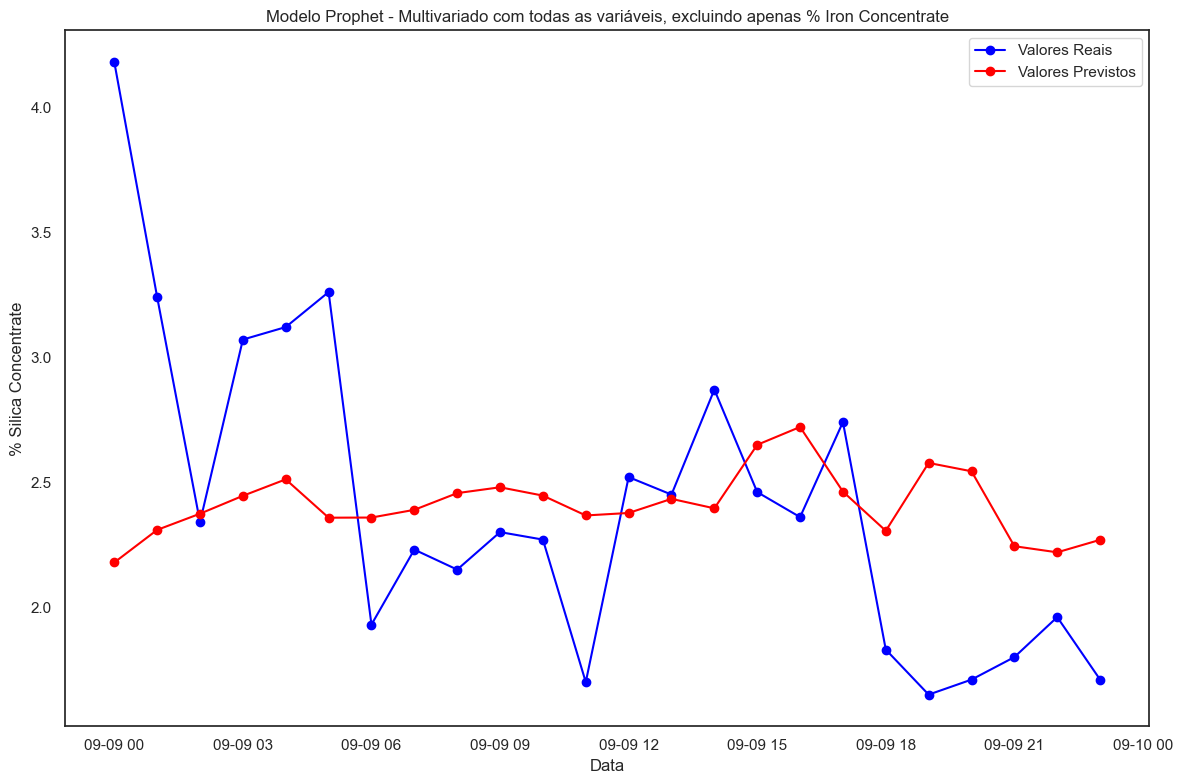

In [80]:
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(teste.ds, teste.y.values, label="Valores Reais", marker="o", color="blue")
plt.plot(y_pred.ds, y_pred.yhat.values, label="Valores Previstos", marker="o", color="red")

plt.ylabel("% Silica Concentrate")
plt.xlabel("Data")
plt.title("Modelo Prophet - Multivariado com todas as variáveis, excluindo apenas % Iron Concentrate")
plt.legend()

plt.tight_layout()

## **Modelo Prophet - Multivariado com variáveis selecionadas, excluindo apenas `% Iron Concentrate`**

### **Ajuste dos hiperparâmetros com Optuna**

In [81]:
def objective(trial):
    growth = trial.suggest_categorical('growth', ['linear', 'logistic', 'flat'])
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.00001, 0.9)

    # Instanciando o modelo
    m = Prophet(growth=growth, changepoint_prior_scale=changepoint_prior_scale)
    m.add_regressor("Amina Flow")
    m.add_regressor("Ore Pulp pH")
    m.add_regressor("Flotation Column 01 Air Flow")
    m.add_regressor("Flotation Column 02 Air Flow")
    m.add_regressor("Flotation Column 03 Air Flow")
    m.add_regressor("Flotation Column 04 Level")
    m.add_regressor("Flotation Column 05 Level")
    m.add_regressor("Flotation Column 06 Level")
    m.add_regressor("Flotation Column 07 Level")
    
    # Treinando o modelo
    m.fit(treino)

    # Fazendo previsões
    val = treino[-24:].reset_index(drop=True)
    previsoes = m.predict(val)

    # Calculado o MAPE
    y_true = val.y.values
    y_pred = previsoes.yhat.values
    mape = (np.mean(np.true_divide(np.abs(y_true-y_pred), y_true)))*100

    return mape

In [82]:
sampler = TPESampler(seed=RANDOM_SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)
#optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=50)

[I 2024-10-19 17:42:56,236] A new study created in memory with name: no-name-f27cd8bf-2330-4353-9877-fccafe5f761d
17:42:56 - cmdstanpy - INFO - Chain [1] start processing
17:42:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-10-19 17:42:57,699] Trial 0 finished with value: 49.33440837327419 and parameters: {'growth': 'logistic', 'changepoint_prior_scale': 0.2721062920429295}. Best is trial 0 with value: 49.33440837327419.
17:42:58 - cmdstanpy - INFO - Chain [1] start processing
17:42:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-10-19 17:42:58,226] Trial 1 finished with value: 44.616043883517605 and parameters: {'growth': 'flat', 'changepoint_prior_scale': 0.3110111987314726}. Best is trial 1 with value: 44.616043883517605.
17:42:58 - cmdstanpy - INFO - Chain [1] start processing
17:42:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-10-19 17:42:59,912] Trial 2 finished with value: 45.41257069224344 and parameters: {'growth': 'logistic', 'changepoint_prio

In [83]:
melhores_parametros = study.best_params

print(f"Melhor MAPE: {study.best_trial.value}")
print(f"Melhores parâmetros: {study.best_params}")

Melhor MAPE: 43.19140324996866
Melhores parâmetros: {'growth': 'linear', 'changepoint_prior_scale': 0.8940513975877659}


### **Treinando o modelo com os parâmetros ajustados**

In [84]:
m = Prophet(
        growth=melhores_parametros['growth'],
        changepoint_prior_scale=melhores_parametros['changepoint_prior_scale']
)

m.add_regressor("Amina Flow")
m.add_regressor("Ore Pulp pH")
m.add_regressor("Flotation Column 01 Air Flow")
m.add_regressor("Flotation Column 02 Air Flow")
m.add_regressor("Flotation Column 03 Air Flow")
m.add_regressor("Flotation Column 04 Level")
m.add_regressor("Flotation Column 05 Level")
m.add_regressor("Flotation Column 06 Level")
m.add_regressor("Flotation Column 07 Level")

m.fit(treino)

17:44:09 - cmdstanpy - INFO - Chain [1] start processing
17:44:10 - cmdstanpy - INFO - Chain [1] done processing


### **Avaliando o modelo**

In [85]:
# Previsões
y_pred = m.predict(teste)

In [86]:
# Visualizando as métricas
eval_metrics(teste.y.values, y_pred.yhat.values)

{'RMSE': 0.6407688131247142,
 'MAE': 0.5158006370499986,
 'MAPE': 21.34269614075366}

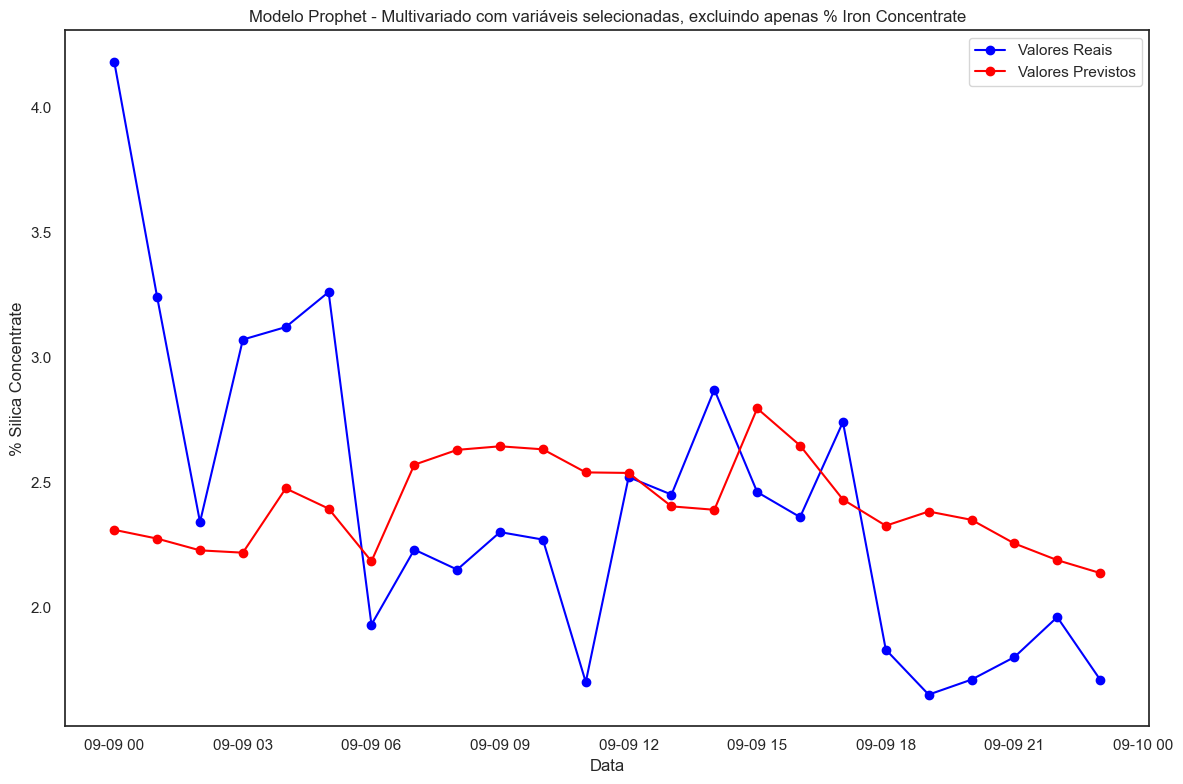

In [87]:
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(teste.ds, teste.y.values, label="Valores Reais", marker="o", color="blue")
plt.plot(y_pred.ds, y_pred.yhat.values, label="Valores Previstos", marker="o", color="red")

plt.ylabel("% Silica Concentrate")
plt.xlabel("Data")
plt.title("Modelo Prophet - Multivariado com variáveis selecionadas, excluindo apenas % Iron Concentrate")
plt.legend()

plt.tight_layout()

## **Modelo Prophet - Univariado**

### **Ajuste dos hiperparâmetros com Optuna**

In [88]:
def objective(trial):
    growth = trial.suggest_categorical('growth', ['linear', 'logistic', 'flat'])
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.00001, 0.9)

    # Instanciando o modelo
    m = Prophet(growth=growth, changepoint_prior_scale=changepoint_prior_scale)
    
    # Treinando o modelo
    m.fit(treino)

    # Fazendo previsões
    val = treino[-24:].reset_index(drop=True)
    previsoes = m.predict(val)

    # Calculado o MAPE
    y_true = val.y.values
    y_pred = previsoes.yhat.values
    mape = (np.mean(np.true_divide(np.abs(y_true-y_pred), y_true)))*100

    return mape

In [89]:
sampler = TPESampler(seed=RANDOM_SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)
#optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=50)

[I 2024-10-19 17:44:11,173] A new study created in memory with name: no-name-b517e2d4-04f1-444d-bcd8-a0032189969c
17:44:11 - cmdstanpy - INFO - Chain [1] start processing
17:44:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-10-19 17:44:12,448] Trial 0 finished with value: 52.06572800575046 and parameters: {'growth': 'logistic', 'changepoint_prior_scale': 0.2721062920429295}. Best is trial 0 with value: 52.06572800575046.
17:44:12 - cmdstanpy - INFO - Chain [1] start processing
17:44:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-10-19 17:44:12,779] Trial 1 finished with value: 41.10288203075426 and parameters: {'growth': 'flat', 'changepoint_prior_scale': 0.3110111987314726}. Best is trial 1 with value: 41.10288203075426.
17:44:13 - cmdstanpy - INFO - Chain [1] start processing
17:44:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-10-19 17:44:15,146] Trial 2 finished with value: 53.45487346935221 and parameters: {'growth': 'logistic', 'changepoint_prior_

In [90]:
melhores_parametros = study.best_params

print(f"Melhor MAPE: {study.best_trial.value}")
print(f"Melhores parâmetros: {study.best_params}")

Melhor MAPE: 37.3327348840769
Melhores parâmetros: {'growth': 'linear', 'changepoint_prior_scale': 0.006408007184575008}


### **Treinando o modelo com os parâmetros ajustados**

In [91]:
m = Prophet(
        growth=melhores_parametros['growth'],
        changepoint_prior_scale=melhores_parametros['changepoint_prior_scale']
)

m.fit(treino)

17:44:49 - cmdstanpy - INFO - Chain [1] start processing
17:44:49 - cmdstanpy - INFO - Chain [1] done processing


### **Avaliando o modelo**

In [92]:
# Previsões
y_pred = m.predict(teste)

In [93]:
# Visualizando as métricas
eval_metrics(teste.y.values, y_pred.yhat.values)

{'RMSE': 0.6242851113880261,
 'MAE': 0.4722223573233942,
 'MAPE': 19.17485227640152}

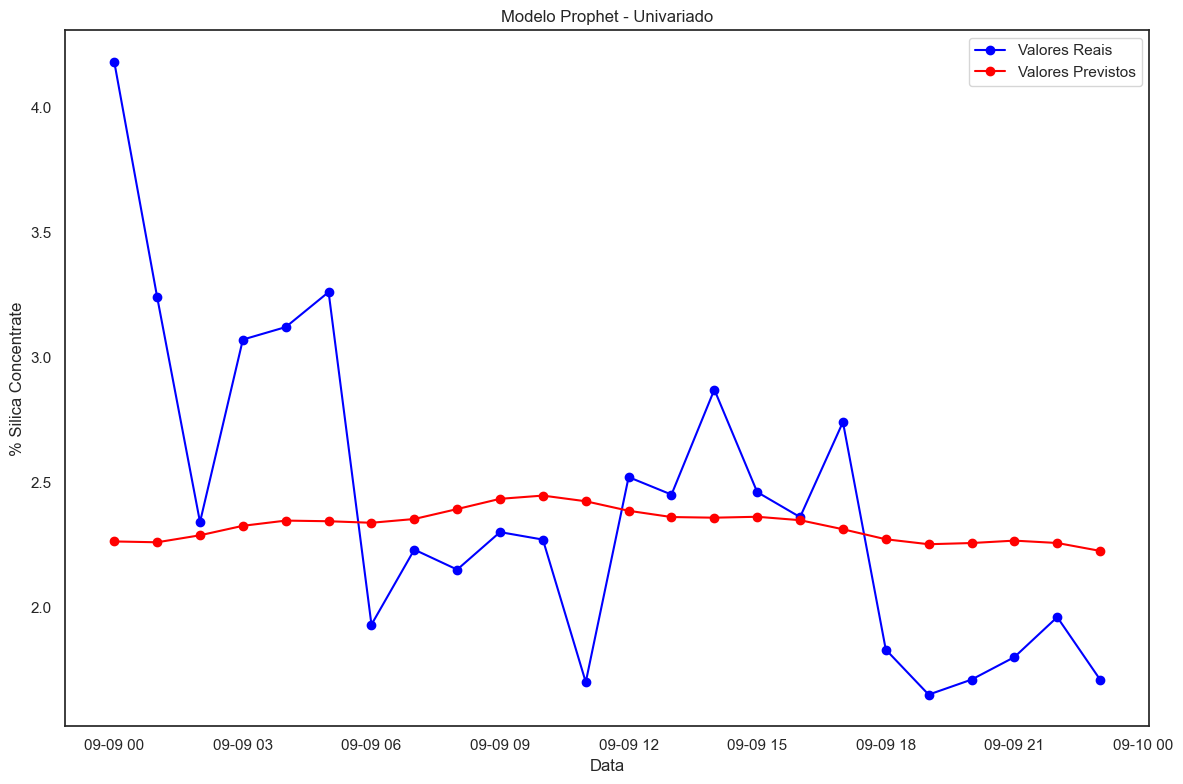

In [94]:
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(teste.ds, teste.y.values, label="Valores Reais", marker="o", color="blue")
plt.plot(y_pred.ds, y_pred.yhat.values, label="Valores Previstos", marker="o", color="red")

plt.ylabel("% Silica Concentrate")
plt.xlabel("Data")
plt.title("Modelo Prophet - Univariado")
plt.legend()

plt.tight_layout()